In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pickle
from magpie_data import NeLMap, FaradayMap, PolarimetryMap, InterferogramOntoPolarimetry
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# Polarimetry
This code block will result in a polarogram, a map of the rotation of the linear polarisation of the probing laser beam.
#### 1. Folder where data is stored
On Windows, you can shift+right-click a folder and choose "Copy as Path"

In [2]:
%cd "C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday\s0919_17 Faraday"

C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday\s0919_17 Faraday


#### 2. Filenames
R0 and R1 are registration images for cameras 0 and 1, which are often the same as B0 and B1, the background images for cameras 0 and 1. S0 and S1 are shot images for cameras 0 and 1. You may have separate registration images if you're using a load which doesn't cast a good shadow with lots of sharpo edges, like a radial foil.

These filenames are entered into a Polarimetry object called s, which has all the functions to process them. You should rotate the images here using rot_angle. Work out the rotation you want with Photoshop by looking at image R0. The rotation angle is in degrees counter clockwise, so clockwise rotations are negative numbers.

In [3]:
R0fn='s0919_17_155048_c1.png'
R1fn='s0919_17_155106_c2.png'
B0fn=R0fn
B1fn=R1fn
S0fn='s0919_17_155920_c1.png'
S1fn='s0919_17_155938_c2.png'
s=PolarimetryMap(R0fn, R1fn, B0fn, B1fn, S0fn, S1fn, rot_angle=-1.8)

### 3a. Either perform image registration
Or go to 3b. below to load an existing transform.
#### Initial Inspection
This plots the initial registration images side by side, with a linked zoom. Use these to find good guesses at the transform for the contraints dictionary below.

<IPython.core.display.Javascript object>


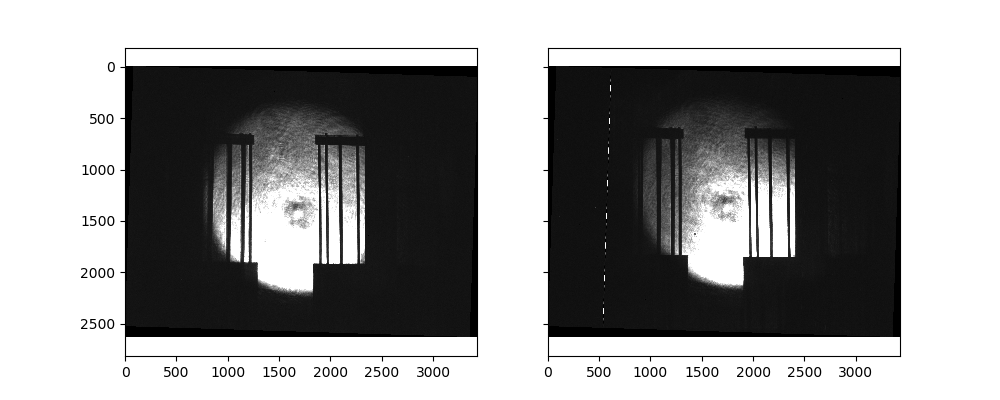

In [4]:
fig, ax=plt.subplots(1,2,sharex=True, sharey=True,figsize=(10,4))
ax[0].imshow(s.R0, clim=[0,0.1], cmap='gray')
ax[1].imshow(s.R1, clim=[0,0.1], cmap='gray')

#### Set constraints
This dictionary contains a good initial guess at the transform between the two registration images, as well as a constraint, eg. 'tx':(100,10) means that the x-transform is likely to be +100 pixels, +/- 10 pixels. Tighter contraint converge faster but might miss the correct solution! For polarimetry, angle is ~0 and scale ~1 as there aren't enough optics to rotate or zoom the images between the cameras.
* Sign convention: +100 means the RIGHT image must be shifted by 100 pixels DOWN/RIGHT to match the LEFT image

In [10]:
constraints={'angle':(0,2),'scale':(1,0.1),'tx':(-80,30),'ty':(+70,30)}

#### Register images
This cell takes a long time to execute, using the constraints above to perform a discrete Fourier transform based technique to overlap the images.

In [11]:
s.register(constraints=constraints)
s.transform_images()

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


#### Inspect transform
This cell shows four images - the two images on the top row are the original registration images. The bottom left image is the transformed version of the top right image - it should overlap the top left image. The bottom right image is the difference between the top and bottom left images, plotted with a diverging colour scale. Ideally, sharp objects would show up in white, but they often have a blue/red halo indicating the transform isn't perfect. 

In reality, due to effects from differing spherical abberation in the two images, it is not possible to get a perfect registration everywhere. If the registration looks good, move on to pickle the transform. If you're not happy, tighten the constraints and run again, or use the nudge tool below.

<IPython.core.display.Javascript object>


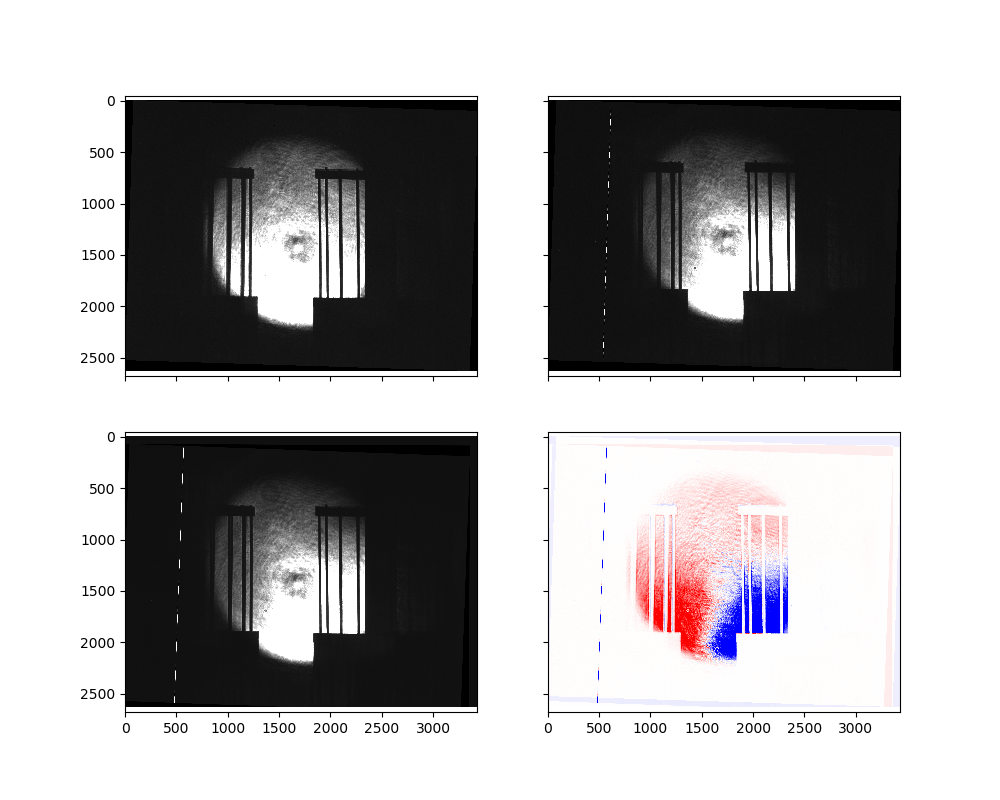

In [14]:
fig, ax=plt.subplots(2,2,sharex=True, sharey=True,figsize=(10,8))
ax[0,0].imshow(s.R0, clim=[0,0.1], cmap='gray')
ax[0,1].imshow(s.R1, clim=[0,0.1], cmap='gray')
ax[1,0].imshow(s.RT, clim=[0,0.1], cmap='gray')
ax[1,1].imshow(s.R0-s.RT, clim=[-0.1,0.1], cmap='bwr')

#### Nudge the transform
Often the transform is close, but not perfect. In particular, it might not be well aligned in the region you're most interested in, and you can sacrifice alignment in another region to perfect it here. Run the cell below and use the sliders to alter the translation, scale and angle. You can also change the limits of the colour map. The sliders can be moved by clicking and dragging, using the arrow keys or by clicking the text and typing in a number.

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


<IPython.core.display.Javascript object>


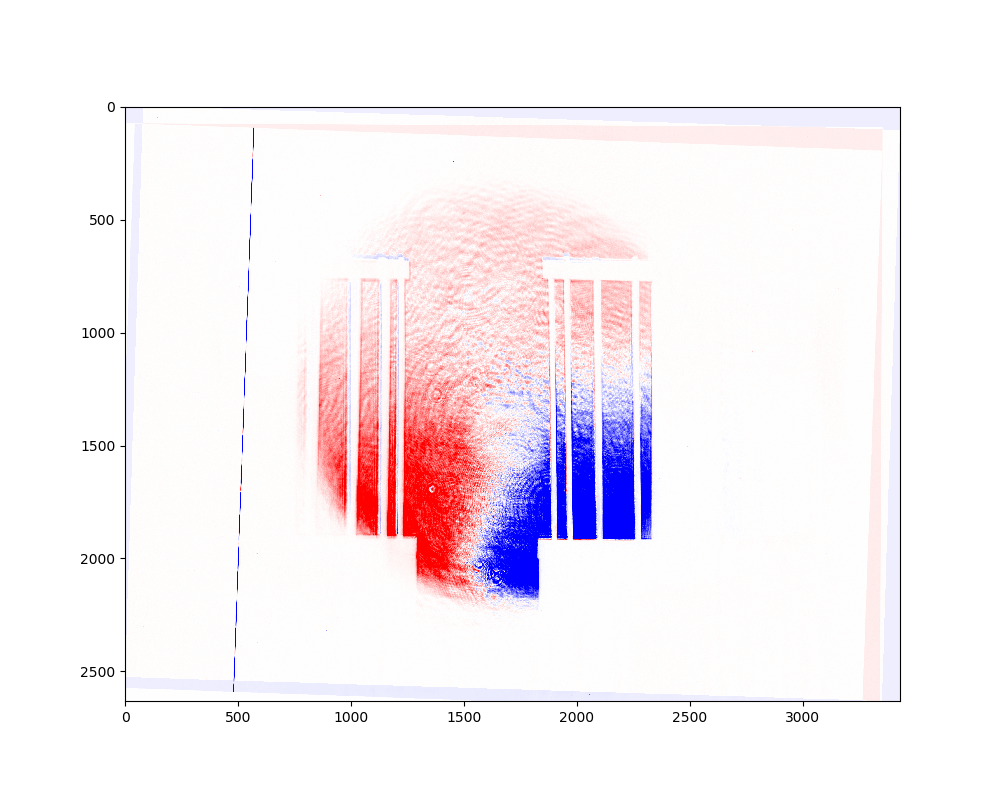

In [15]:
s.nudge_transform()

#### Confirm the nudge
If you're happy with the new nudge version, use confirm nudge to save it. Or you can ignore this cell and discard your nudge by going straight to the cell below.

In [16]:
s.confirm_nudge()

#### Pickle transform
Pickling is python's name for saving a copy of an object - in this case the dictionary containing the successful transform. The cell below saves a file called eg. s1003_17 faraday trgistration.p into the folder with the faraday images. It can then be loaded using step 3b. below in future.

In [17]:
s.save_transform(fn=s.fn[:8]+' faraday registration.p')
s.transform_images()

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdhare\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


## 3b. Or load an existing registration
Unpickle a previous transform. Don't try and reuse transforms between shots, it rarely works well...

In [4]:
s.load_transform()
s.transform_images()

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdhare\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


#### Plot the data to check it looks okay
By default, this uses a diverging blue-white-red colour scale. You can alter the limits of the colormap by altering 'clim=[-2,2]', but keep the numbers symmetric otherwise the scale makes no sense...

<IPython.core.display.Javascript object>


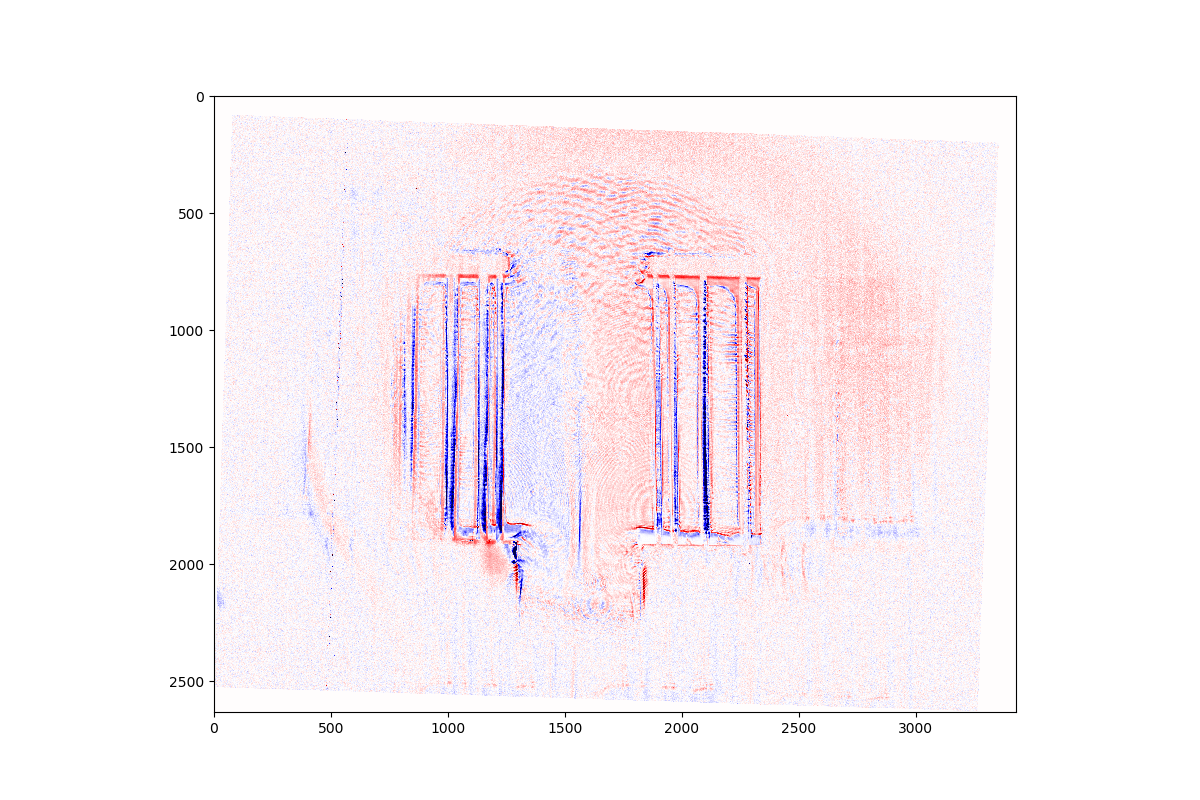

In [5]:
s.convert_to_alpha()
s.plot_data_px(clim=[-2,2])

#### 4. Assign scale, origin and crop
The scale is probably 59.5 pixels/mm, but you can check if you have an item of hardware you're sure of the size of.
The origin is in (x,y) pixel coordinates. Photoshop is the best tool to find these, using the Ruler tool, but you can get a rough idea from the plots of the reigstration images above.
Extent is the region to be cropped in the form [bottom,top,left,right], in mm. Eg. [-5,10,0,4] selects a region from -5 to 10 mm (measured from the set origin) in y, and 0 to 4 mm in x.

In [6]:
s.scale=59.5
s.set_origin((1329,1554), extent=[-12,12,-10,10])

C:\Users\jdhare\Documents\GitHub\magpie_tools\code\magpie_data.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


#### 5. Make a nice plot
This code makes a neat plot of your data. You can change the limits of the colourmap by changing max_angle. The axies labels are z and x by default, reflecting the most common Magpie experiments.

<IPython.core.display.Javascript object>


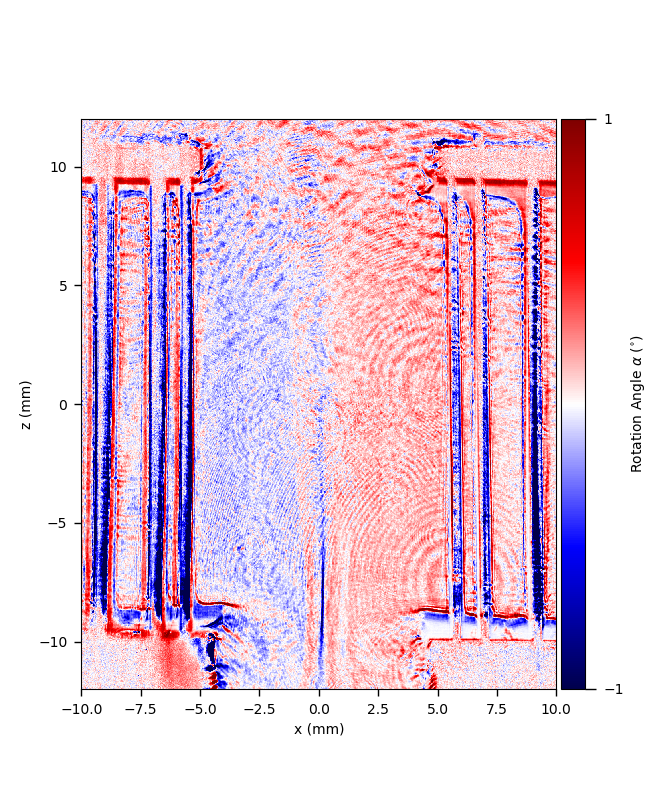

In [7]:
max_angle=1.0

fig, ax=plt.subplots(figsize=(6.5,8))
far=s.plot_data_mm(ax=ax, clim=[-max_angle,max_angle])

ax.set_xlabel('x (mm)')
ax.set_ylabel('z (mm)')

#ax.set_xticks([-20,-15,-10,-5,0]) # you can use these to specify which tick labels you have
#ax.set_yticks([-10,-5,0,5,10])

ax.tick_params(pad=5, length=5, width=1)
ax.get_yaxis().set_label_coords(-0.1,0.5)

ax_cb = make_axes_locatable(ax).new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
fig.colorbar(far, cax=ax_cb, ticks=[-max_angle,max_angle])
ax_cb.set_ylabel(r'Rotation Angle $\alpha$ ($^{\circ}$)')
ax_cb.tick_params(pad=5, length=8, width=1)

#### 7. Save the plot
The filename is set automatically, but you can choose which folder the image goes in - good if you're making pictures for a conference and don't want to move them.

In [11]:
folder=r'~\some\folder\in\your\home\directory\like\Downloads'
fn=s.fn[:8]+' polarogram.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jdhare\\some\\folder\\in\\your\\home\\directory\\like\\Downloads\\s0919_17 polarogram.png'

#### 6. Lineouts
You can create lineouts to get a quantitative feel for how the polarisation angle changes.

This default example takes a lineout along a line of constant z. Start is the coordinates in mm of the start point (x,y), end is the coordinates in mm of the end point, and the lineout_width_mm is the width in mm. Note that the width is the total width of lineout, so a lineout of h averages over -h/2 to + h/2 around the line.

Changing this to a lineout along constant x is simple, just change the start and end coordinates.

The mm scale for these lineouts is hard to define (think about diagonal lines), so we create a new array (x) using linspace to plot with.

<IPython.core.display.Javascript object>


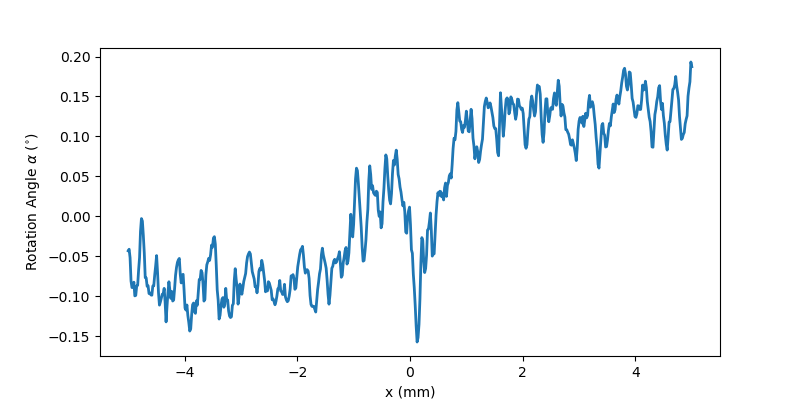

In [26]:
zz=0
xstart=-5
xend=5
s.create_lineout(start=(zz,xstart),end=(zz,xend),lineout_width_mm=1)

fig,ax=plt.subplots(figsize=(8,4))
x=np.linspace(xstart,xend,s.mm.size)
ax.plot(x,s.lo, lw=2)
ax.set_xlabel('x (mm)')
ax.set_ylabel(r'Rotation Angle $\alpha$ ($^{\circ}$)')

#### 8. Save lineouts
As above!

In [ ]:
folder=r'~\some\folder\in\your\home\directory\like\Downloads'
fn=s.fn[:8]+' lineout.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)

# Overlay Interferometry
This is a less used code block, but it can be useful to work out whether a given shot is worth tracing the interferometry for. It overlays a transparent version of the shot interferogram onto the polarimetry map so you can compare fringe shifts to rotation angles.

The good news is that if you do the image registration here, you can reuse it in for the electron density map to work out the magnetic field in the final section. This is pretty good!
#### Load the files
Change to the folder where the interferometry data is stored, usually the level above where the Faraday data is stored.

I0 is a shadow image which corresponds to the R0 image above - it should have the same features in, and no interference fringes!

I1 is the shot interferogram.

IO is an object that has functions to place the interferogram onto the rotation map. It contains the Polarimetry object s.

In [8]:
%cd "C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday"
I0fn="s0919_17 IR side on interferometry (2).JPG"
I1fn="s0919_17 IR side on interferometry (1).JPG"
I=InterferogramOntoPolarimetry(s, I0fn, I1fn)

C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday


### 3a. Either perform image registration
Or go to 3b. below to load an existing transform.
#### Initial Inspection
This plots the initial registration images side by side, with a linked zoom. Use these to find good guesses at the transform for the contraints dictionary below.

<IPython.core.display.Javascript object>


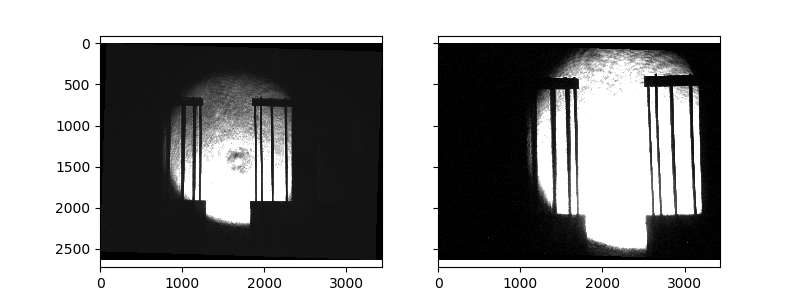

In [30]:
fig, ax=plt.subplots(1,2,sharex=True, sharey=True,figsize=(8,3))
ax[0].imshow(I.R0, clim=[0,0.1], cmap='gray')
ax[1].imshow(I.R1, clim=[0,0.1], cmap='gray')

#### Set constraints
This dictionary contains a good initial guess at the transform between the two registration images, as well as a constraint, eg. 'tx':(100,10) means that the x-transform is likely to be +100 pixels, +/- 10 pixels. Tighter contraint converge faster but might miss the correct solution! For aligning interferometry on Faraday, the scale is around 0.7, rotation can be relatively large and the translation is similarly big - the registration takes time and will need to be iterated - it's tedious!

In [31]:
constraints={'angle':(-2,3),'scale':(0.79,0.05),'tx':(-460,100),'ty':(-50,100)}

#### Register images
This cell takes a long time to execute, using the constraints above to perform a discrete Fourier transform based technique to overlap the images.

In [32]:
I.register(constraints=constraints)
I.transform_images()

C:\Users\jdhare\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


#### Inspect transform
This cell shows four images - the two images on the top row are the original registration images. The bottom left image is the transformed version of the top right image - it should overlap the top left image. The bottom right image is the difference between the top and bottom left images, plotted with a diverging colour scale. Ideally, sharp objects would show up in white, but they often have a blue/red halo indicating the transform isn't perfect. 

In reality, due to effects from differing spherical abberation in the two images, it is not possible to get a perfect registration everywhere. If the registration looks good, move on to pickle the transform. If you're not happy, tighten the constraints and run again, or use the nudge tool below.

<IPython.core.display.Javascript object>


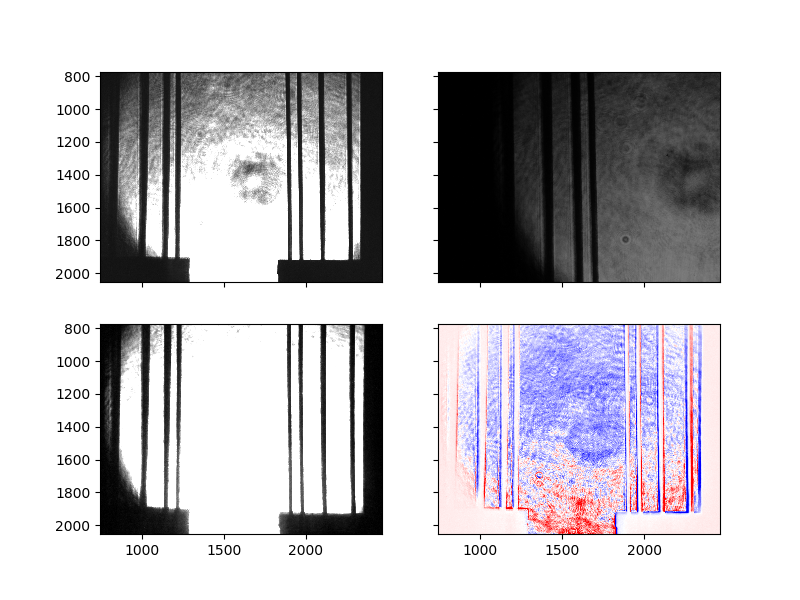

In [41]:
fig, ax=plt.subplots(2,2,sharex=True, sharey=True,figsize=(8,6))
ax[0,0].imshow(I.R0, clim=[0,0.1], cmap='gray')
ax[0,1].imshow(I.R1, clim=[0,1], cmap='gray')
ax[1,0].imshow(I.RT, clim=[0,0.1], cmap='gray')
ax[1,1].imshow(I.R0-0.5*I.RT, clim=[-0.1,0.1], cmap='bwr')

#### Nudge the transform
Often the transform is close, but not perfect. In particular, it might not be well aligned in the region you're most interested in, and you can sacrifice alignment in another region to perfect it here. Run the cell below and use the sliders to alter the translation, scale and angle. You can also change the limits of the colour map. The sliders can be moved by clicking and dragging, using the arrow keys or by clicking the text and typing in a number.

<IPython.core.display.Javascript object>


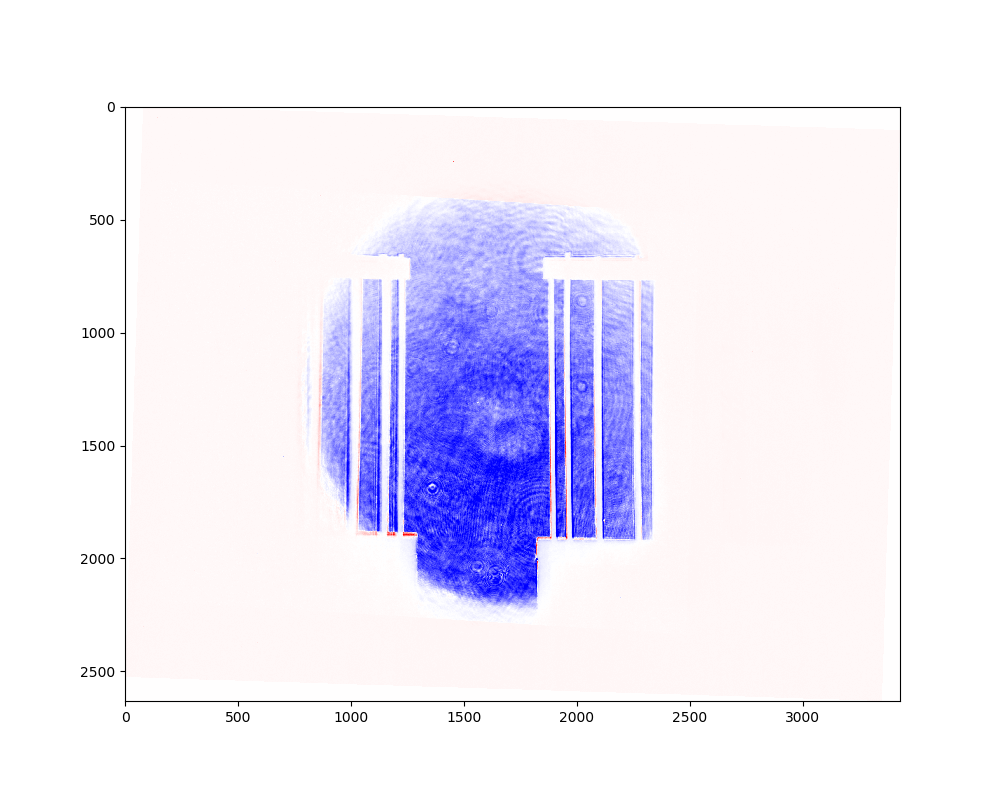

In [37]:
I.nudge_transform()

#### Confirm the nudge
If you're happy with the new nudge version, use confirm nudge to save it. Or you can ignore this cell and discard your nudge by going straight to the cell below.

In [42]:
I.confirm_nudge()

#### Pickle transform
Pickling is python's name for saving a copy of an object - in this case the dictionary containing the successful transform. The cell below saves a file called eg. s1003_17 faraday trgistration.p into the folder with the faraday images. It can then be loaded using step 3b. below in future.

In [43]:
I.save_transform(fn=s.fn[:8]+' interferometry registration.p')
I.transform_images()

## 3b. Or load an existing registration
Unpickle a previous transform. Don't try and reuse transforms between shots, it rarely works well...

In [9]:
I.load_transform()
I.transform_images()

## 4. Overlay Interferogram on Polarogram
First run the cell below to copy and crop area from the polarogram.

In [10]:
I.scale=s.scale
I.set_origin(s.origin, extent=s.extent[2:4]+s.extent[0:2])

C:\Users\jdhare\Documents\GitHub\magpie_tools\code\magpie_data.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


#### Plot the overlay
You change how transparent the fringes are using alpha.

<IPython.core.display.Javascript object>


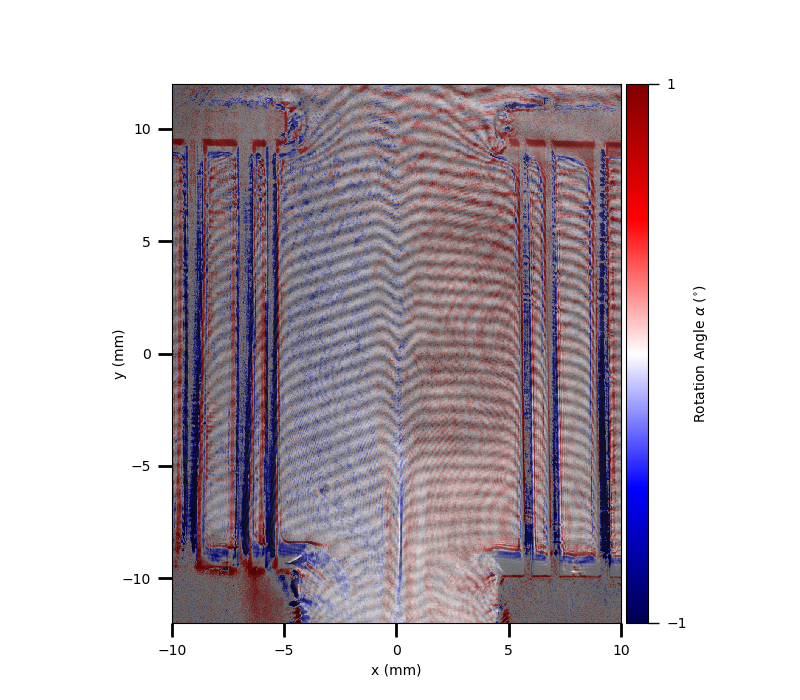

In [11]:
alpha=0.6

fig, ax=plt.subplots(figsize=(8,7))
far=s.plot_data_mm(ax=ax, clim=[-1,1])

ax.set_xlabel('x (mm)',fontsize=10)
ax.set_ylabel('y (mm)',fontsize=10)

ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-10,-5,0,5,10])

ax.tick_params(labelsize=10, pad=5, length=10, width=2)
ax.get_yaxis().set_label_coords(-0.1,0.5)

ax.imshow(I.data_c, cmap='gray', alpha=alpha, extent=s.extent)

ax_cb = make_axes_locatable(ax).new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
fig.colorbar(far, cax=ax_cb, ticks=[-max_angle,max_angle])
ax_cb.set_ylabel(r'Rotation Angle $\alpha$ ($^{\circ}$)')
ax_cb.tick_params(pad=5, length=8, width=1)

#### 7. Save the plot
The filename is set automatically, but you can choose which folder the image goes in - good if you're making pictures for a conference and don't want to move them.

In [17]:
folder=r'C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday'
fn=s.fn[:8]+' polarogram with interferometry.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)

# Bring in The Density Map

In [42]:
I0fn="s0919_17 IR side on interferometry (2).JPG"
nefn="s0919_17 IR side on neL.txt"
b=FaradayMap(s, I0fn, nefn)

#### 1. Load the transform
This is the same transform generated when the interferogram was registered to the polarimetry data, and so it can be reused.

In [43]:
b.load_transform()
b.transform_images()

#### 2. Clip data
In regions where there is no electron density data (inside the mask), this results in a very large field, as we are dividing the rotation angle by a very small number. It is useful to mask this data.
Set the value clip below: data outside -clip to +clip will be set to NaN. A relatively large number is reasonable to avoid your data being spoiled by white spots.

In [61]:
clip=100

b.convert_to_magnetic_field()
b.B[(b.B<-clip)|(b.B>clip)]=np.nan
b.scale=s.scale
b.set_origin(s.origin, extent=s.extent[2:4]+[-5,5])

C:\Users\jdhare\Documents\GitHub\magpie_tools\code\magpie_data.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data_c=self.data[ymin:ymax, xmin:xmax]


#### 3. Plot magnetic field map
We take the scale and origin from the polarimetry data, as before, and plot the magnetic field between -max_field and +max_field. 

<IPython.core.display.Javascript object>


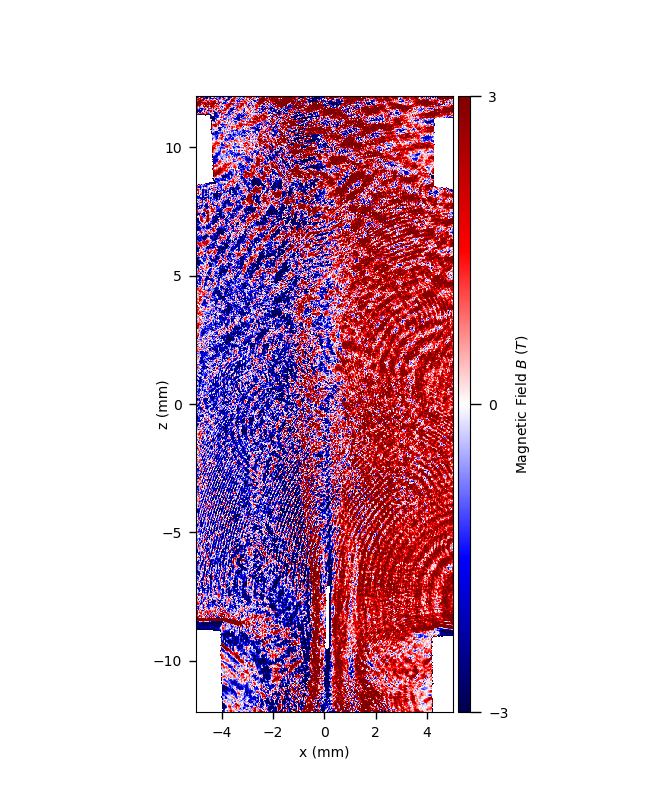

In [62]:
max_field=3

fig, ax=plt.subplots(figsize=(6.5,8))
far=b.plot_data_mm(ax=ax, clim=[-max_field,max_field])

ax.set_xlabel('x (mm)')
ax.set_ylabel('z (mm)')

#ax.set_xticks([-20,-15,-10,-5,0]) # you can use these to specify which tick labels you have
#ax.set_yticks([-10,-5,0,5,10])

ax.tick_params(pad=5, length=5, width=1)
ax.get_yaxis().set_label_coords(-0.1,0.5)

ax_cb = make_axes_locatable(ax).new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
fig.colorbar(far, cax=ax_cb, ticks=[-max_field,0, max_field])
ax_cb.set_ylabel(r'Magnetic Field $B$ ($T$)')
ax_cb.tick_params(pad=5, length=8, width=1)

#### 4. Save the image
Obviously at this point you'll want to save an image of your beautiful data:

In [ ]:
folder=r'C:\Users\jdhare\Google Drive\MAGPIE\data\2017\s0919_17 C reconnection Faraday'
fn=s.fn[:8]+' faraday.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)

#### 5. Lineouts
You can create lineouts to get a quantitative feel for how the polarisation angle changes.

This default example takes a lineout along a line of constant z. Start is the coordinates in mm of the start point (x,y), end is the coordinates in mm of the end point, and the lineout_width is the width in pixels (so we usually use s.scale* some number in mm to set a width in mm). Note that the width is the total width of lineout, so a lineout of h averages over -h/2 to + h/2 around the line.

Changing this to a lineout along constant x is simple, just change the start and end coordinates.

The mm scale for these lineouts is hard to define (think about diagonal lines), so we create a new array (x) using linspace to plot with.

<IPython.core.display.Javascript object>


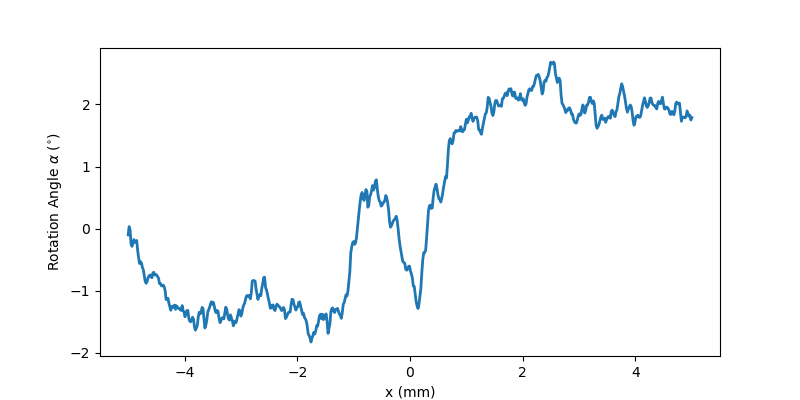

In [55]:
zz=0
xstart=-5
xend=5
b.create_lineout(start=(zz,xstart),end=(zz,xend),lineout_width_mm=10)

fig,ax=plt.subplots(figsize=(8,4))
x=np.linspace(xstart,xend,b.mm.size)
ax.plot(x,b.lo, lw=2)
ax.set_xlabel('x (mm)')
ax.set_ylabel(r'Rotation Angle $\alpha$ ($^{\circ}$)')

#### 6. Save lineouts
As above!

In [ ]:
folder=r'~\some\folder\in\your\home\directory\like\Downloads'
fn=s.fn[:8]+' lineout.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)